# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os

os.getcwd()
os.chdir('/content/drive/My Drive/Project 9')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np

#Here the inp data contains 2 array: 0 represent image and 1 represents bounding box of faces
inp_data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)

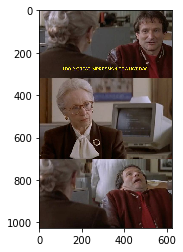

In [25]:
import matplotlib.pyplot as plt

plt.imshow(inp_data[8][0])

In [26]:
#This displays the plot for the faces in the image
#This image shows it has 2 faces

print(inp_data[8][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.136, 'y': 0.32456140350877194}, {'x': 0.4704, 'y': 0.5555555555555556}], 'imageWidth': 625, 'imageHeight': 1026}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.5552, 'y': 0.7066276803118908}, {'x': 0.8608, 'y': 0.8489278752436648}], 'imageWidth': 625, 'imageHeight': 1026}]


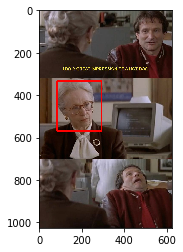

In [27]:
import cv2

cv2.imwrite('img_8_0.jpg',inp_data[8][0])

path = r'img_8_0.jpg'
image = cv2.imread(path, 1) 

start_point = (int(0.136*625), int(0.32456140350877194*1026))
end_point = (int(0.4704*625), int(0.5555555555555556*1025)) 

image=cv2.rectangle(image,start_point,end_point,(255, 0, 0),5)

plt.imshow(image)


#We have drawn a rectangle box over the face using the y value of the image

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
#Since MobileNet uses image with 224*224

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#As given the question, the width and height has been set to 224 for all the images

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [29]:
#No fo rows in inp_data - total no images
inp_data.shape[0]

#No fo cols in inp_data - image,boundary box of face
inp_data.shape[1]

print(inp_data.shape[0],inp_data.shape[1])

409 2


In [0]:
#This is for the preprocessing of the Input images

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(inp_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(inp_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(inp_data.shape[0]):
    img = inp_data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in inp_data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [31]:
X_train.shape

#409 images,each images is 224*224 pixel,3 represents RGB value

(409, 224, 224, 3)

In [32]:
masks.shape

#409 images,each images is 224*224 pixel
#here it simply represnts the boundary box

(409, 224, 224)

### Print a sample image and image array

[[[ 0.5529412   0.43529415 -0.09019607]
  [ 0.6156863   0.49803925 -0.02745098]
  [ 0.62352943  0.50588238 -0.01960784]
  ...
  [ 0.74117649  0.34117651 -0.48235291]
  [ 0.56078434  0.14509809 -0.67058825]
  [ 0.60784316  0.16078436 -0.63137257]]

 [[ 0.57647061  0.45882356 -0.04313725]
  [ 0.63921571  0.52156866  0.01176476]
  [ 0.57647061  0.45882356 -0.05098039]
  ...
  [ 0.70980394  0.3176471  -0.49803919]
  [ 0.66274512  0.24705887 -0.56862748]
  [ 0.6156863   0.16078436 -0.63137257]]

 [[ 0.63921571  0.52156866  0.01176476]
  [ 0.63921571  0.52156866  0.01176476]
  [ 0.5529412   0.43529415 -0.0745098 ]
  ...
  [ 0.73333335  0.35686278 -0.4588235 ]
  [ 0.67843139  0.27058828 -0.52156866]
  [ 0.69411767  0.24705887 -0.56078434]]

 ...

 [[-0.5529412  -0.96862745 -0.96862745]
  [-0.48235291 -0.98431373 -0.98431373]
  [-0.48235291 -0.98431373 -1.        ]
  ...
  [-0.96078432 -0.99215686 -0.99215686]
  [-0.9137255  -0.96078432 -0.95294118]
  [-0.93725491 -0.99215686 -0.98431373]]

 [

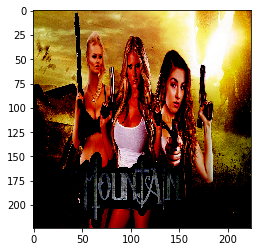

In [33]:
n = 100
print(X_train[n])
plt.imshow(X_train[n])

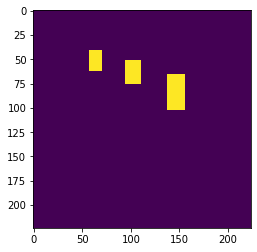

In [34]:
#Masking the faces in the previous image

plt.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

##Need for up sampling
The output of semantic segmentation is not just a class label or some bounding box parameters. In-fact the output is a complete high resolution image in which all the pixels are classified.
Thus if we use a regular convolutional network with pooling layers and dense layers, we will lose the “WHERE” information and only retain the “WHAT” information which is not what we want. In case of segmentation we need both “WHAT” as well as “WHERE” information.
Hence there is a need to up sample the image, i.e. convert a low resolution image to a high resolution image to recover the “WHERE” information.
In the literature, there are many techniques to up sample an image. Some of them are bi-linear interpolation, cubic interpolation, nearest neighbor interpolation, unpooling, transposed convolution, etc. However in most state of the art networks, transposed convolution is the preferred choice for up sampling an image.

In [0]:
#Ths below link explains the UNET and need for upsampling
# https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape,Dropout,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNet


def create_model(trainable=True):
    #### Conv part from Mobile Net and not the Fully connected layer####
    #include_top=False is used to skip the top layers
    model=MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top=False,alpha=1.0,weights='imagenet')
    '''
    for layer in model.layers:
        layer.trainable = trainable
    '''

    #Taking layers from 20 till end
    for layer in model.layers[20:]:
        layer.trainable=True
    #Removing first 20 layers for training
    for layer in model.layers[:20]:
        layer.trainable=trainable

    #Upsampling part
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [36]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=False)

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
import tensorflow as tf


def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss,optimizer=optimizer,metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [41]:
#Fitting the model

model.fit(x=X_train,y=masks,batch_size=1,epochs=50,verbose=1,callbacks=[checkpoint,stop,reduce_lr])

Train on 409 samples
Epoch 1/50

Epoch 00001: loss improved from inf to 5.27037, saving model to model-5.27.h5


  1/409 [..............................] - ETA: 1:01:39 - loss: 5.2704 - dice_coefficient: 0.0626
Epoch 00001: loss improved from 5.27037 to 1.79789, saving model to model-1.80.h5


  2/409 [..............................] - ETA: 31:33 - loss: 3.5341 - dice_coefficient: 0.3318  
Epoch 00001: loss did not improve from 1.79789



Epoch 00001: loss did not improve from 1.79789
  4/409 [..............................] - ETA: 15:50 - loss: 3.7259 - dice_coefficient: 0.2399
Epoch 00001: loss did not improve from 1.79789

Epoch 00001: loss did not improve from 1.79789
  6/409 [..............................] - ETA: 10:35 - loss: 3.9515 - dice_coefficient: 0.2039
Epoch 00001: loss did not improve from 1.79789

Epoch 00001: loss did not improve from 1.79789
  8/409 [..............................] - ETA: 7:57 - loss: 3.7554 - dice_coefficient: 0.2067 
Epoch 00001: loss did not improve from 1.79789

Epoch 00001: loss did not improve from 1.79789
 10/409 [..............................] - ETA: 6:22 - loss: 3.5205 - dice_coefficient: 0.2226
Epoch 00001: loss improved from 1.79789 to 1.70294, saving model to model-1.70.h5
 11/409 [..............................] - ETA: 5:56 - loss: 3.3552 - dice_coefficient: 0.2454
Epoch 00001: loss did not improve from 1.70294

Epoch 00001: loss did not improve from 1.70294
 13/409 [...

### Get the predicted mask for a sample image   (3 marks)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.9802322e-08 2.9802322e-08 2.9802322e-08 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


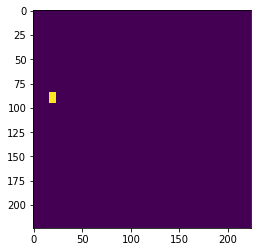

In [47]:
n = 33
sample_image = X_train[n]
region = model.predict(x=np.array([sample_image]))[0]
print(region)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > 0.95:
          region[i][j]=1;
        else:
          region[i][j]=0;  
plt.imshow(region)

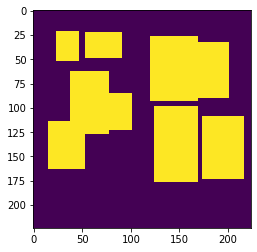

In [43]:
plt.imshow(masks[33])

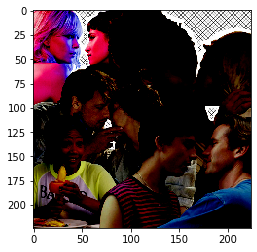

In [44]:
plt.imshow(X_train[33])

### Impose the mask on the image (3 marks)

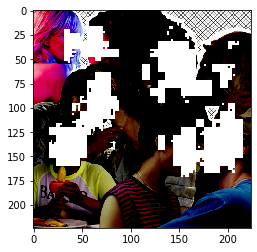

In [45]:
#Imposing masks over the image

Maskimage = X_train[33];
Maskimage.shape
for k in range(Maskimage.shape[2]):  
    for j in range(Maskimage.shape[1]):
        for i in range(Maskimage.shape[0]):
            if region[i][j]==1:
              Maskimage[i][j][k]=1  
                  

plt.imshow(Maskimage)

Thus using MobileNet model as Transfer Learning and UNET upsampling these images are trained and the masks are drawn over the image.